In [ ]:
#This code computes medians of errors and uses bootstrapping to calculate errors of medians

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import bootstrap

In [5]:
#Read errors and take rmse

all_errors=pd.read_csv('../data/'+ 'all_errors_interpolation' + '.csv',index_col=0)
columns=["sigma", "function","rmse_nn_interp.", "rmse_nn_extrap.", "rmse_mdl_interp.", "rmse_mdl_extrap.","r"]
all_errors=all_errors[columns]
display(all_errors)

,sigma,function,rmse_nn_interp.,rmse_nn_extrap.,rmse_mdl_interp.,rmse_mdl_extrap.,r
0,0.0,tanh,0.012386,0.060146,0.001340,0.011199,0
1,0.0,tanh,0.012122,0.026266,0.003454,0.454497,0
2,0.0,tanh,0.006643,0.085908,0.001222,0.069993,0
3,0.0,tanh,0.001461,0.089270,0.000406,0.048799,0
4,0.0,tanh,0.002459,0.014093,0.000248,0.003921,0
...,...,...,...,...,...,...,...
655,0.2,leaky_ReLU,0.087048,0.182138,0.010784,0.164822,2
656,0.2,leaky_ReLU,0.127071,0.610832,0.142086,0.234066,2
657,0.2,leaky_ReLU,0.105589,4.418359,0.041496,0.046699,2
658,0.2,leaky_ReLU,0.141243,3.278076,0.114628,0.176435,2


In [6]:
#Melt dataframe: make two columns with the type of errors for the train and the values of the errors
errors_inter=all_errors[["sigma", "function","rmse_nn_interp.", "rmse_mdl_interp.","r"]]
errors_inter=pd.melt(errors_inter,id_vars=["sigma","function","r"], var_name="error_interp.",value_name= "value_interp.")

errors_extra=all_errors[["sigma", "function","rmse_nn_extrap.", "rmse_mdl_extrap.","r"]]
errors_extra=pd.melt(errors_extra,id_vars=["sigma","function", "r"], var_name="error_extrap.", value_name= "value_extrap.")

display(errors_inter)

display(errors_extra)

,sigma,function,r,error_interp.,value_interp.
0,0.0,tanh,0,rmse_nn_interp.,0.012386
1,0.0,tanh,0,rmse_nn_interp.,0.012122
2,0.0,tanh,0,rmse_nn_interp.,0.006643
3,0.0,tanh,0,rmse_nn_interp.,0.001461
4,0.0,tanh,0,rmse_nn_interp.,0.002459
...,...,...,...,...,...
1315,0.2,leaky_ReLU,2,rmse_mdl_interp.,0.010784
1316,0.2,leaky_ReLU,2,rmse_mdl_interp.,0.142086
1317,0.2,leaky_ReLU,2,rmse_mdl_interp.,0.041496
1318,0.2,leaky_ReLU,2,rmse_mdl_interp.,0.114628


,sigma,function,r,error_extrap.,value_extrap.
0,0.0,tanh,0,rmse_nn_extrap.,0.060146
1,0.0,tanh,0,rmse_nn_extrap.,0.026266
2,0.0,tanh,0,rmse_nn_extrap.,0.085908
3,0.0,tanh,0,rmse_nn_extrap.,0.089270
4,0.0,tanh,0,rmse_nn_extrap.,0.014093
...,...,...,...,...,...
1315,0.2,leaky_ReLU,2,rmse_mdl_extrap.,0.164822
1316,0.2,leaky_ReLU,2,rmse_mdl_extrap.,0.234066
1317,0.2,leaky_ReLU,2,rmse_mdl_extrap.,0.046699
1318,0.2,leaky_ReLU,2,rmse_mdl_extrap.,0.176435


In [7]:
#Separate tanh and leaky ReLU
errors_tanh_inter=errors_inter[errors_inter['function']=='tanh']
errors_tanh_extra=errors_extra[errors_extra['function']=='tanh']

errors_leaky_inter=errors_inter[errors_inter['function']=='leaky_ReLU']
errors_leaky_extra=errors_extra[errors_extra['function']=='leaky_ReLU']

display(errors_tanh_inter)
display(errors_leaky_inter)

,sigma,function,r,error_interp.,value_interp.
0,0.0,tanh,0,rmse_nn_interp.,0.012386
1,0.0,tanh,0,rmse_nn_interp.,0.012122
2,0.0,tanh,0,rmse_nn_interp.,0.006643
3,0.0,tanh,0,rmse_nn_interp.,0.001461
4,0.0,tanh,0,rmse_nn_interp.,0.002459
...,...,...,...,...,...
985,0.2,tanh,2,rmse_mdl_interp.,0.038005
986,0.2,tanh,2,rmse_mdl_interp.,0.116825
987,0.2,tanh,2,rmse_mdl_interp.,0.116529
988,0.2,tanh,2,rmse_mdl_interp.,0.076724


,sigma,function,r,error_interp.,value_interp.
330,0.0,leaky_ReLU,0,rmse_nn_interp.,0.012477
331,0.0,leaky_ReLU,0,rmse_nn_interp.,0.009077
332,0.0,leaky_ReLU,0,rmse_nn_interp.,0.010683
333,0.0,leaky_ReLU,0,rmse_nn_interp.,0.005229
334,0.0,leaky_ReLU,0,rmse_nn_interp.,0.005580
...,...,...,...,...,...
1315,0.2,leaky_ReLU,2,rmse_mdl_interp.,0.010784
1316,0.2,leaky_ReLU,2,rmse_mdl_interp.,0.142086
1317,0.2,leaky_ReLU,2,rmse_mdl_interp.,0.041496
1318,0.2,leaky_ReLU,2,rmse_mdl_interp.,0.114628


In [8]:
#Figure configuration
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 8*cm; height=6*cm

Extensions=['.png', '.pdf']

#colors from seaborn's colorblind palette
color_data=sns.color_palette("colorblind")[0]
color_noise=sns.color_palette("colorblind")[7]
color_ann=sns.color_palette("colorblind")[4]
color_bms=sns.color_palette("colorblind")[2]

#Fonts and sizes                                                                                    
size_axis=12;size_ticks=10;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
m_size=6

output_path='../results/'

resamples=100000; bs_seed=1111 #number of resamples
ymin=2e-4;ymax=0.75

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 [Text(0, 9.999999999999999e-06, '$\\mathdefault{10^{-5}}$'),
  Text(0, 9.999999999999999e-05, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.09999999999999999, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$')])

<Figure size 944.882x708.661 with 0 Axes>

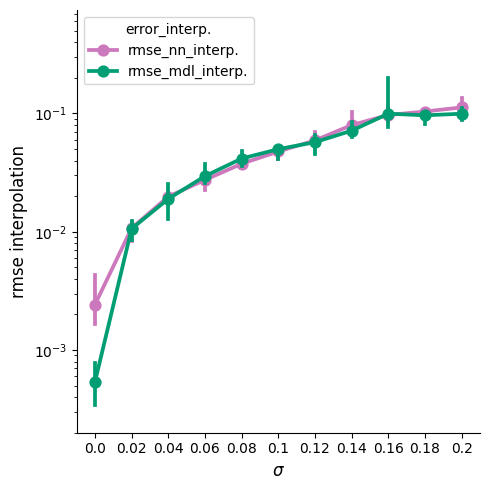

<Figure size 944.882x708.661 with 0 Axes>

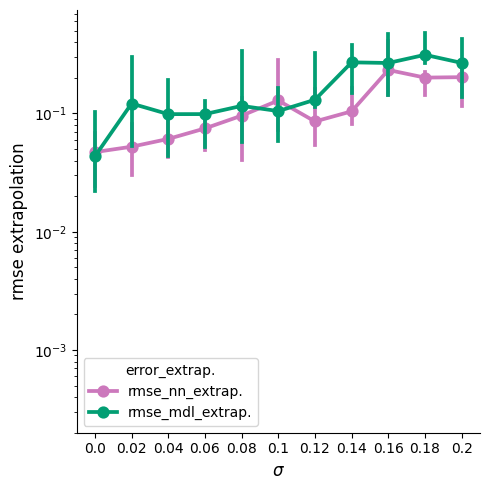

In [9]:
#Plot tanh interpolation
#----------------------------------------------------------------------------------------------------------------------
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_tanh_inter, x='sigma', y='value_interp.', hue='error_interp.', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)

plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse interp',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig= 'interpolation_medians_tanh'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse interpolation',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#----------------------------------------------------------------------------------------------------------------------

#Plot tanh extrapolation
#----------------------------------------------------------------------------------------------------------------------
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_tanh_extra, x='sigma', y='value_extrap.', hue='error_extrap.', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)

plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse extrap',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig= 'extrapolation_medians_tanh'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse extrapolation',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#----------------------------------------------------------------------------------------------------------------------

(0.0002, 0.75)

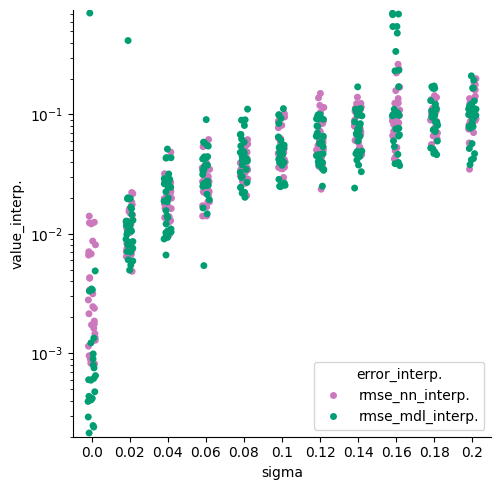

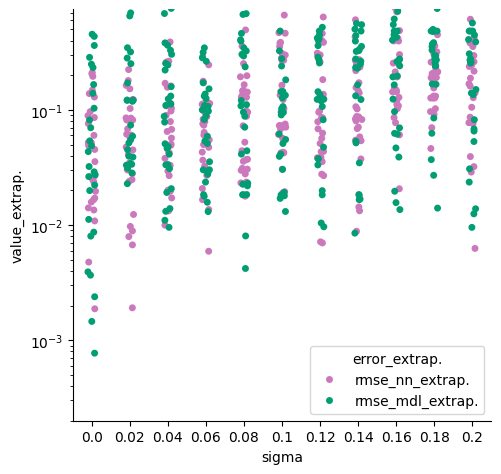

In [10]:
#Plot individual simulations
sns.catplot(data=errors_tanh_inter, x='sigma', y='value_interp.', hue='error_interp.',palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)

sns.catplot(data=errors_tanh_extra, x='sigma', y='value_extrap.', hue='error_extrap.',palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 [Text(0, 9.999999999999999e-06, '$\\mathdefault{10^{-5}}$'),
  Text(0, 9.999999999999999e-05, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.09999999999999999, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$')])

<Figure size 944.882x708.661 with 0 Axes>

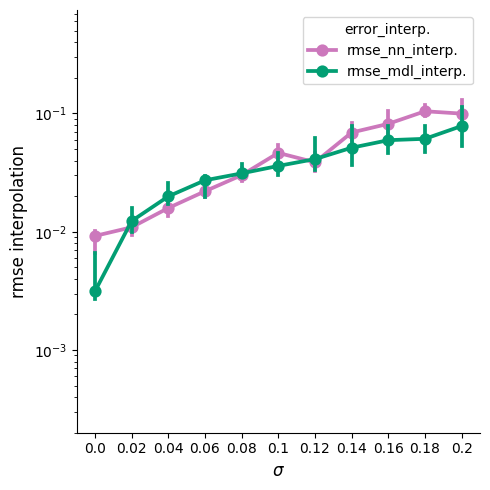

<Figure size 944.882x708.661 with 0 Axes>

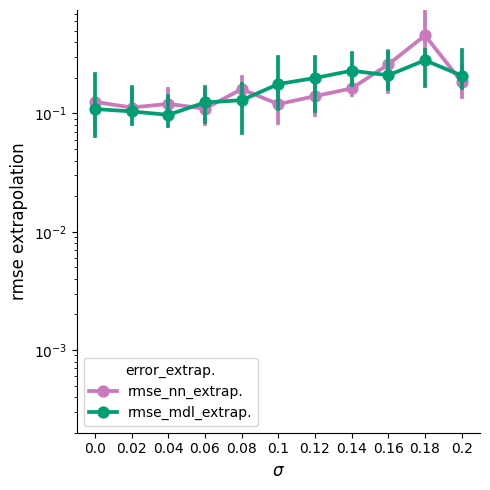

In [11]:
#Plot leaky interpolation
#----------------------------------------------------------------------------------------------------------------------
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_leaky_inter, x='sigma', y='value_interp.', hue='error_interp.', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)

plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse interp',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig= 'interpolation_medians_leaky'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse interpolation',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#----------------------------------------------------------------------------------------------------------------------

#Plot tanh extrapolation
#----------------------------------------------------------------------------------------------------------------------
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_leaky_extra, x='sigma', y='value_extrap.', hue='error_extrap.', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)

plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse extrap',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig='extrapolation_medians_leaky'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse extrapolation',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#----------------------------------------------------------------------------------------------------------------------

(0.0002, 0.75)

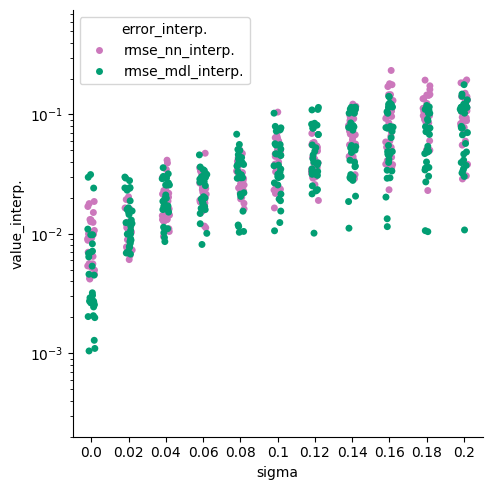

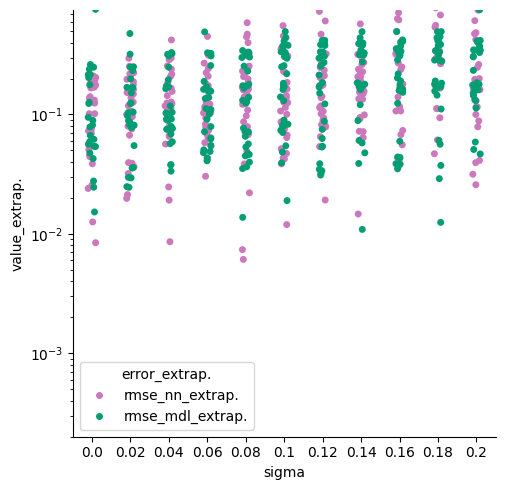

In [12]:
#Plot individual simulations leaky
sns.catplot(data=errors_leaky_inter, x='sigma', y='value_interp.', hue='error_interp.',palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)

sns.catplot(data=errors_leaky_extra, x='sigma', y='value_extrap.', hue='error_extrap.',palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)